## 8. Model Diagnostics

**Exercise 8.1**.  For an AR(1) model with $\phi \approx 0.5$ and $n = 100$, the lag 1 sample autocorrelation of the residuals is 0.5.  Should we consider this unusual?  Why or why not?

**Solution**.  From Equation (8.1.5),

$$ \text{Var}[\hat{r}_1] \approx \frac{\phi^2}{n} $$

so the standard error of the sample correlation to be approximately 0.05, and we should expect the lag 1 sample autocorrelation to be within 2 standard errors, $\pm 0.1$.  A value of 0.5 is unusual.

**Exercise 8.2**.  Repeat Exercise 8.1 for an MA(1) model with $\theta \approx 0.5$ and and $n = 100$.

**Solution**.  Page 183 indicates that we can replace $\phi$ with $\theta$ for MA(1) models, so

$$ \text{Var}[\hat{r}_1] \approx \frac{\theta^2}{n} $$

Once again the standard error of the sample correlation is approximately 0.05, and we should expect the lag 1 sample autocorrelation to be within 2 standard errors, $\pm 0.1$.  A value of 0.5 is unusual.

**Exercise 8.3**.  Based on a series of length $n = 200$, we fit an AR(2) model and obtain residual autocorrelations of $\hat{r}_1 = 0.13$, $\hat{r}_2 = 0.13$, and $\hat{r}_3 = 0.12$.  If $\hat{\phi}_1 = 1.1$ and $\hat{\phi}_2 = −0.8$, do these residual autocorrelations support the AR(2) specification?  Individually  Jointly?

**Solution**.  Equations (8.1.8), (8.1.9) and (8.1.10) state that, for the AR(2) model,

$$
\text{Var}[\hat{r}_1] \approx \frac{\phi_2^2}{n},
\quad
\text{Var}[\hat{r}_2] \approx \frac{\phi_2^2 + \phi_1^2(1 + \phi_2)^2}{n},
\quad
\text{Var}[\hat{r}_k] \approx \frac{1}{n} \quad \text{for } k \geq 3
$$

Replacing in the given values, we get

$$
2 \sqrt{\text{Var}[\hat{r}_1]} \approx 0.113,
\quad
2 \sqrt{\text{Var}[\hat{r}_2]} \approx 0.117,
\quad
2 \sqrt{\text{Var}[\hat{r}_k]} \approx 0.141 \quad \text{for } k \geq 3
$$

The residual autocorrelations for $\hat{r}_1$ and $\hat{r}_2$ are above those thresholds, while the residual autocorrelation for $\hat{r}_3$ is under the corresponding threshold.

The Ljung-Box statistic is

$$ Q_* = n(n+2) \left( \frac{\hat{r}_1^2}{n - 1} + \frac{\hat{r}_2^2}{n - 2} + \frac{\hat{r}_3^2}{n - 3} \right) $$

which, replacing values, gives $Q_* \approx 9.832$.  If the AR(2) speficication is correct, then $Q_*$ should have approximately a chi-square distribution with 3 - 2 = 1 degree of freedom.  But $\text{Pr}[\chi_1^2 > Q_*] \approx 0.0017$, so the residual correlations are jointly too large to support the AR(2) specification at p-value 0.01.

In [1]:
n = 200
r1, r2, r3 = 0.13, 0.13, 0.12
Qstar = n * (n + 2) * (r1**2/(n-1) + r2**2/(n-2) + r3**2/(n-3))

print(Qstar)

9.832334048852683


In [2]:
from scipy.stats import chi2

print(1 - chi2.cdf(Qstar, df=1))

0.0017147062472285812


**Exercise 8.4**.  Simulate an AR(1) model with $n = 30$ and $\phi = 0.5$.

**(a)** Fit the correctly specified AR(1) model and look at a time series plot of the residuals.  Does the plot support the AR(1) specification?

**(b)** Display a normal quantile-quantile plot of the standardized residuals.  Does the plot support the AR(1) specification?

**(c)** Display the sample ACF of the residuals.  Does the plot support the AR(1) specification?

**(d)** Calculate the Ljung-Box statistic summing to $K = 8$.  Does this statistic support the AR(1) specification?

**Solution**.

In [3]:
import numpy as np
import pandas as pd
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.arima_model import ARIMA
from tqdm import tqdm_notebook
import warnings

import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
def generate_arima(phi=[], d=0, theta=[], n=100):
    """
    Generates an ARIMA distribution with specified phi, d, and theta parameters.
    """
    
    ar = np.r_[1, -np.array(phi)]
    ma = np.r_[1, -np.array(theta)]
    Y = ArmaProcess(ar, ma).generate_sample(nsample=n)
    for i in range(d):
        Y = np.cumsum(Y)
    return Y

In [5]:
np.random.seed(0)
Y = generate_arima(phi=[0.5], n=30)

**(a)**

In [6]:
fitted_model = ARIMA(Y, order=(1, 0, 0)).fit(method='mle')

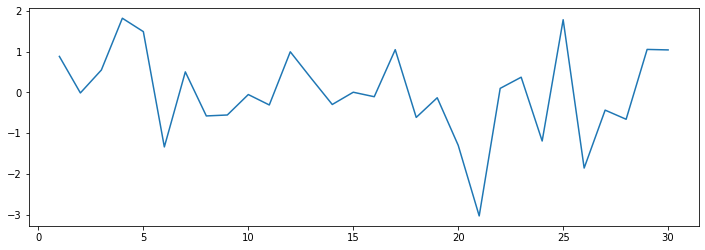

In [7]:
plt.figure(figsize=(12, 4))
plt.plot(range(1, len(fitted_model.resid) + 1), fitted_model.resid)
plt.show()

These residuals look "random".

**(b)**

In [8]:
import statsmodels.api as sm

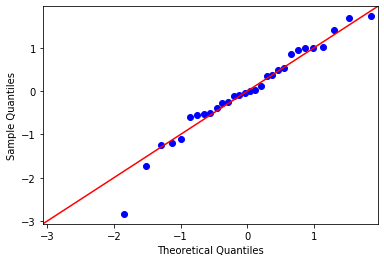

In [9]:
probplot = sm.ProbPlot(fitted_model.resid, fit=True)
fig = probplot.qqplot(line='45')
plt.show()

The lower tail looks suspect; the plot otherwise looks sensible.  Doing a Shapiro-Wilk test to verify normality:

In [10]:
from scipy.stats import shapiro

In [11]:
W, p_value = shapiro(fitted_model.resid)
p_value

0.4845081865787506

Shapiro-Wilk fails to reject normality.

**(c)**

In [12]:
from statsmodels.tsa.stattools import acf, pacf

def plot_acf_with_bounds(acf, lower, upper, title='ACF'):
    max_k = len(acf)
    k = range(1, len(acf)+1)
    
    plt.figure(figsize=(12, 4))
    plt.fill_between(k, lower, upper, color='C0', alpha=0.2)

    plt.plot(k, acf, marker='o', linestyle='none', color='C0')
    plt.plot([1, max_k], [0, 0], ls=':', color='C0')
    for i_k, i_rho in zip(k, acf):
        plt.plot([i_k, i_k], [0, i_rho], color='C0')    
    
    plt.xlabel('Lag')
    plt.ylabel(r'$\rho_k$')
    plt.title(title)
    plt.show()

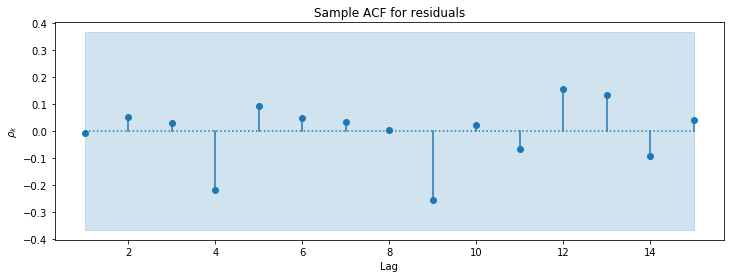

In [13]:
r = acf(fitted_model.resid, fft=False, nlags=15)[1:]
se = 1 / np.sqrt(len(fitted_model.resid))
plot_acf_with_bounds(r, -2*se, 2*se, title='Sample ACF for residuals')

The sample ACF supports the residuals being random.

**(d)**

In [14]:
from scipy.stats import chi2

def ljung_box_test(r, n, k_ar=0, k_ma=0):
    nlags = len(r)
    denominators = np.arange(n-1, n-1-nlags, step=-1)
    Qstar = n * (n-2) * np.sum(r**2 / denominators)
    df = nlags - k_ar - k_ma
    p_value = 1 - chi2.cdf(Qstar, df=df)
    
    return {
        'X-squared': Qstar,
        'df': df,
        'p-value': p_value
    }

In [15]:
ljung_box_test(r=acf(fitted_model.resid, fft=False, nlags=8)[1:], n=len(Y), k_ar=1)

{'X-squared': 2.0225685691662245, 'df': 7, 'p-value': 0.9585806863868557}

The test does not reject randomness of error based on the first 8 autocorrelations.

**Exercise 8.5**. Simulate an MA(1) model with $n = 36$ and $\theta = −0.5$.

**(a)** Fit the correctly specified MA(1) model and look at a time series plot of the residuals.  Does the plot support the MA(1) specification?

**(b)** Display a normal quantile-quantile plot of the standardized residuals.  Does the plot support the MA(1) specification?

**(c)** Display the sample ACF of the residuals.  Does the plot support the MA(1) specification?

**(d)** Calculate the Ljung-Box statistic summing to K = 6.  Does this statistic support the MA(1) specification?

**Solution**.

In [16]:
np.random.seed(1000)
Y = generate_arima(theta=[-0.5], n=36)

**(a)**

In [17]:
fitted_model = ARIMA(Y, order=(0, 0, 1)).fit(method='mle')

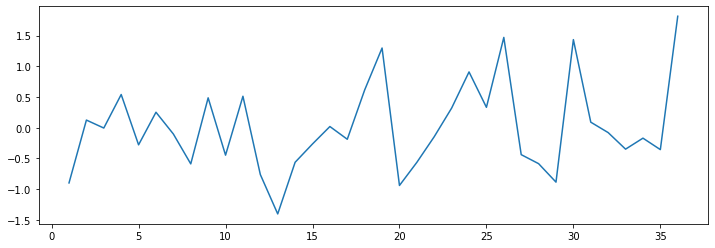

In [18]:
plt.figure(figsize=(12, 4))
plt.plot(range(1, len(fitted_model.resid) + 1), fitted_model.resid)
plt.show()

These residuals look random.

**(b)**

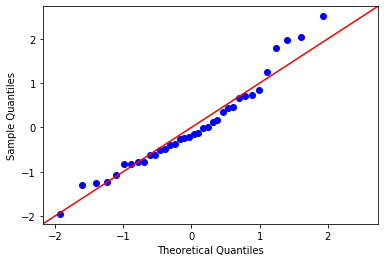

In [19]:
probplot = sm.ProbPlot(fitted_model.resid, fit=True)
fig = probplot.qqplot(line='45')
plt.show()

The upper tail looks suspect, but the residuals do look random.  Doing a Shapiro-Wilk test to confirm:

In [20]:
W, p_value = shapiro(fitted_model.resid)
p_value

0.16901949048042297

Shapiro-Walk fails to reject normality.

**(c)**

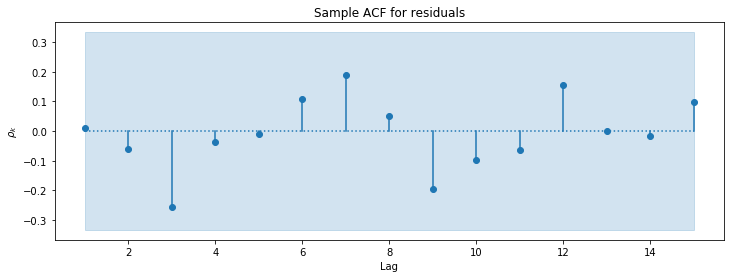

In [21]:
r = acf(fitted_model.resid, fft=False, nlags=15)[1:]
se = 1 / np.sqrt(len(fitted_model.resid))
plot_acf_with_bounds(r, -2*se, 2*se, title='Sample ACF for residuals')

ACF supports residuals being random.

**(d)**

In [22]:
ljung_box_test(r=acf(fitted_model.resid, fft=False, nlags=6)[1:], n=len(Y), k_ma=1)

{'X-squared': 3.1238224861745865, 'df': 5, 'p-value': 0.680902808042148}

The test does not reject randomness of error based on the first 6 autocorrelations.

**Exercise 8.6**.  Simulate an AR(2) model with $n = 48$, $\phi_1 = 1.5$, and $\phi_2 = −0.75$.

**(a)** Fit the correctly specified AR(2) model and look at a time series plot of the residuals.  Does the plot support the AR(2) specification?

**(b)** Display a normal quantile-quantile plot of the standardized residuals.  Does the plot support the AR(2) specification?

**(c)** Display the sample ACF of the residuals.  Does the plot support the AR(2) specification?

**(d)** Calculate the Ljung-Box statistic summing to K = 12.  Does this statistic support the AR(2) specification?

**Solution**.

In [23]:
np.random.seed(2000)
Y = generate_arima(phi=[1.5, -0.75], n=48)

**(a)**

In [24]:
fitted_model = ARIMA(Y, order=(2, 0, 0)).fit(method='mle')

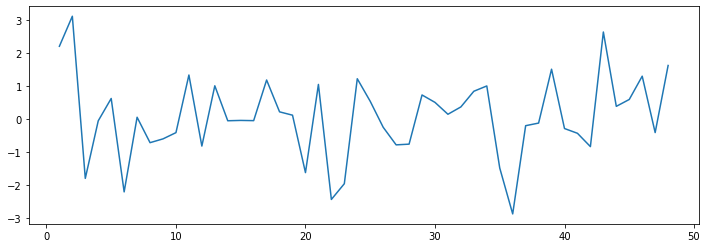

In [25]:
plt.figure(figsize=(12, 4))
plt.plot(range(1, len(fitted_model.resid) + 1), fitted_model.resid)
plt.show()

The residuals look random.

**(b)**

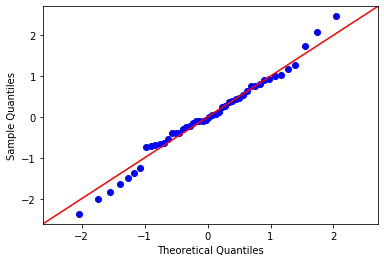

In [26]:
probplot = sm.ProbPlot(fitted_model.resid, fit=True)
fig = probplot.qqplot(line='45')
plt.show()

Tails are a bit suspect in both directions.  Doing Shapiro-Wilk test for normality:

In [27]:
W, p_value = shapiro(fitted_model.resid)
p_value

0.8312253952026367

The test fails to reject normality in residuals.

**(c)**

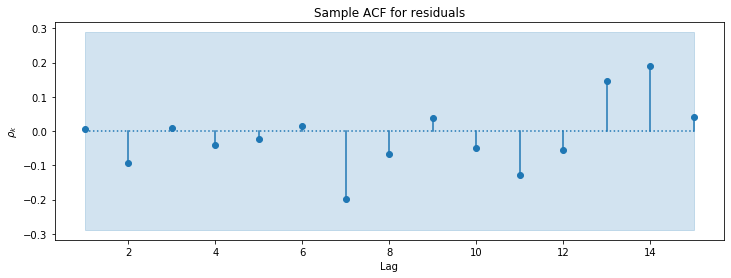

In [28]:
r = acf(fitted_model.resid, fft=False, nlags=15)[1:]
se = 1 / np.sqrt(len(fitted_model.resid))
plot_acf_with_bounds(r, -2*se, 2*se, title='Sample ACF for residuals')

The ACF plot supports residuals being random.

**(d)**

In [29]:
ljung_box_test(r=acf(fitted_model.resid, fft=False, nlags=12)[1:], n=len(Y), k_ar=2)

{'X-squared': 4.33538315392091, 'df': 10, 'p-value': 0.9309516131660488}

The test does not reject randomness of error based on the first 12 autocorrelations.

**Exercise 8.7**.  Fit an AR(3) model by maximum likelihood to the square root of the hare abundance series (filename `hare`).

**(a)** Plot the sample ACF of the residuals. Comment on the size of the correlations.

**(b)** Calculate the Ljung-Box statistic summing to $K = 9$.  Does this statistic support the AR(3) specification?

**(c)** Perform a runs test on the residuals and comment on the results.

**(d)** Display the quantile-quantile normal plot of the residuals. Comment on the plot.

**(e)** Perform the Shapiro-Wilk test of normality on the residuals.

**Solution**.

In [30]:
Y = pd.read_csv('../data/hare.dat')['hare']
fitted_model = ARIMA(Y, order=(3, 0, 0)).fit(method='mle')

**(a)**

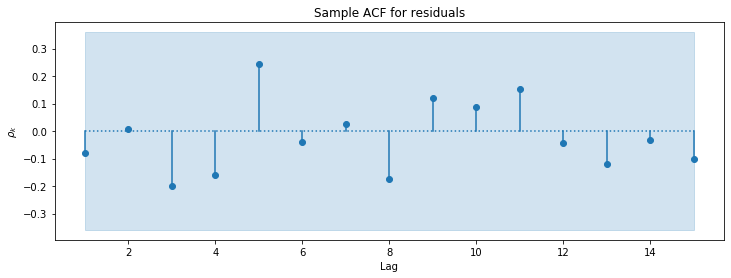

In [31]:
r = acf(fitted_model.resid, fft=False, nlags=15)[1:]
se = 1 / np.sqrt(len(fitted_model.resid))
plot_acf_with_bounds(r, -2*se, 2*se, title='Sample ACF for residuals')

Autocorrelation on residuals are small, and suggest no significant values.

**(b)**

In [32]:
ljung_box_test(r=acf(fitted_model.resid, fft=False, nlags=9)[1:], n=len(Y), k_ar=3)

{'X-squared': 6.263336107723415, 'df': 6, 'p-value': 0.3943468413694613}

The statistic supports the specification.

**(c)**

In [33]:
from statsmodels.sandbox.stats.runs import runstest_1samp

z_stat, p_value = runstest_1samp(fitted_model.resid, cutoff='mean', correction=False)
print('Z statistic:\t %.3f' % z_stat)
print('p-value:\t %.3f' % p_value)

Z statistic:	 0.715
p-value:	 0.475


The p-value does not reject independence of terms.

**(d)**

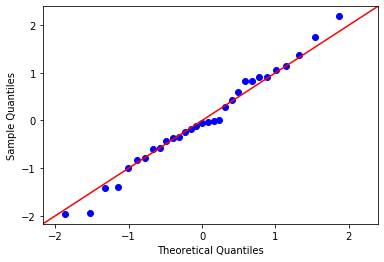

In [34]:
probplot = sm.ProbPlot(fitted_model.resid, fit=True)
fig = probplot.qqplot(line='45')
plt.show()

Residuals look normal.

**(e)**

In [35]:
W, p_value = shapiro(fitted_model.resid)
p_value

0.9186546802520752

Shapiro-Wilk fails to reject normality of residuals.

**Exercise 8.8**.  Consider the oil filter sales data shown in Exhibit 1.8 on page 7.  The data are in the file named `oilfilters`.

**(a)** Fit an AR(1) model to this series. Is the estimate of the $\phi$ parameter significantly different from zero statistically?

**(b)** Display the sample ACF of the residuals from the AR(1) fitted model. Comment on the display.

**Solution**.

In [36]:
Y = pd.read_csv('../data/oilfilters.dat')['oilfilters']

**(a)**

In [37]:
fitted_model = ARIMA(Y, order=(1, 0, 0)).fit(method='mle')
fitted_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:             oilfilters   No. Observations:                   48
Model:                     ARMA(1, 0)   Log Likelihood                -409.187
Method:                           mle   S.D. of innovations           1217.703
Date:                Tue, 12 May 2020   AIC                            824.373
Time:                        13:39:04   BIC                            829.987
Sample:                             0   HQIC                           826.495
                                                                              
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const             3370.5394    253.156     13.314      0.000    2874.363    3866.715
ar.L1.oilfilters     0.3116      0.137      2.277      0.023       0.043       0.580
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            3.2098           +0.0000j            3.2098            0.0000
-----------------------------------------------------------------------------
"""

Yes -- the estimate for $\phi$ is more than 2 standard errors away from zero.

**(b)**

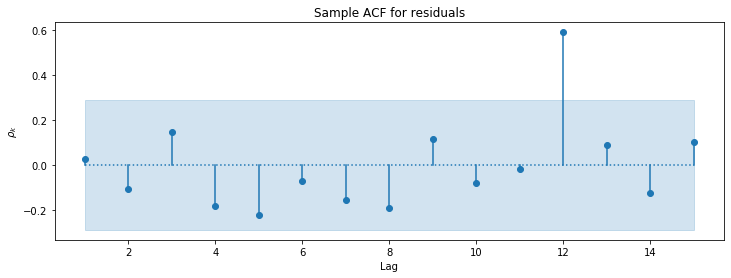

In [38]:
r = acf(fitted_model.resid, fft=False, nlags=15)[1:]
se = 1 / np.sqrt(len(fitted_model.resid))
plot_acf_with_bounds(r, -2*se, 2*se, title='Sample ACF for residuals')

There is a significant autocorrelation lag at 12.  This suggests the series may contain seasonality not captured by the model.

**Exercise 8.9**.  The data file named `robot` contains a time series obtained from an industrial robot.  The robot was put through a sequence of maneuvers, and the distance from a desired ending point was recorded in inches.  This was repeated 324 times to form the time series.  Compare the fits of an AR(1) model and an IMA(1, 1) model for these data in terms of the diagnostic tests discussed in this chapter.

**Solution**.

In [39]:
Y = pd.read_csv('../data/robot.dat')['robot']

In [40]:
model_ar1 = ARIMA(Y, order=(1, 0, 0)).fit(method='mle')
model_ar1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                  robot   No. Observations:                  324
Model:                     ARMA(1, 0)   Log Likelihood                1475.539
Method:                           mle   S.D. of innovations              0.003
Date:                Tue, 12 May 2020   AIC                          -2945.078
Time:                        13:39:05   BIC                          -2933.735
Sample:                             0   HQIC                         -2940.550
                                                                              
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.0015      0.000      7.128      0.000       0.001       0.002
ar.L1.robot     0.3075      0.053      5.823      0.000       0.204       0.411
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            3.2519           +0.0000j            3.2519            0.0000
-----------------------------------------------------------------------------
"""

In [41]:
model_ima11 = ARIMA(Y, order=(0, 1, 1)).fit(method='mle')
model_ima11.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                D.robot   No. Observations:                  323
Model:                 ARIMA(0, 1, 1)   Log Likelihood                1480.953
Method:                           mle   S.D. of innovations              0.002
Date:                Tue, 12 May 2020   AIC                          -2955.906
Time:                        13:39:05   BIC                          -2944.573
Sample:                             1   HQIC                         -2951.382
                                                                              
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -1.275e-06   1.81e-05     -0.071      0.944   -3.67e-05    3.41e-05
ma.L1.D.robot    -0.8716      0.039    -22.178      0.000      -0.949      -0.795
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
MA.1            1.1473           +0.0000j            1.1473            0.0000
-----------------------------------------------------------------------------
"""

Both models have significant estimates for their coefficients.  The AIC score for the IMA(1, 1) model is slightly smaller.

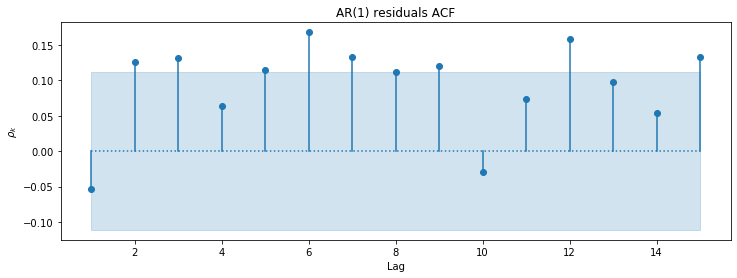

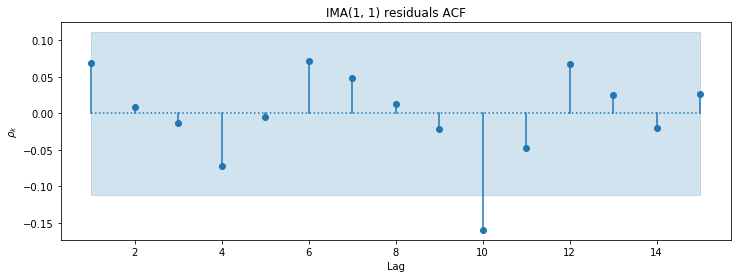

In [42]:
def plot_residuals_acf(resid, title, nlags=15):
    r = acf(resid, fft=False, nlags=nlags)[1:]
    se = 1 / np.sqrt(len(resid))
    plot_acf_with_bounds(r, -2*se, 2*se, title=title)

plot_residuals_acf(model_ar1.resid, 'AR(1) residuals ACF')
plot_residuals_acf(model_ima11.resid, 'IMA(1, 1) residuals ACF')

The residuals for the AR(1) model have too much autocorrelation; the residuals for the IMA(1, 1) model show too much correlation only at lag 10.

This conclusion is confirmed by the Ljung-Box tests: the AR(1) residuals have, collectively, too much correlation, while the residuals from the IMA(1, 1) fit do not.

In [43]:
ljung_box_test(r=acf(model_ar1.resid, fft=False, nlags=12)[1:], n=len(Y), k_ar=1)

{'X-squared': 51.83936482204375, 'df': 11, 'p-value': 2.9153070468801445e-07}

In [44]:
ljung_box_test(r=acf(model_ima11.resid, fft=False, nlags=12)[1:], n=len(Y), k_ma=1)

{'X-squared': 16.76306765065655, 'df': 11, 'p-value': 0.11508196360689282}

Finally, Shapiro-Wilk test p-values do not reject normality in either of the residuals:

In [45]:
shapiro(model_ar1.resid)[1]

0.9192295074462891

In [46]:
shapiro(model_ima11.resid)[1]

0.8087267875671387

**Exercise 8.10**.  The data file named `deere3` contains 57 consecutive values from a complex machine tool at Deere & Co.  The values given are deviations from a target value in units of ten millionths of an inch.  The process employs a control mechanism
that resets some of the parameters of the machine tool depending on the magnitude of deviation from target of the last item produced.  Diagnose the fit of an AR(1) model for these data in terms of the tests discussed in this chapter.

**Solution**.

In [47]:
Y = pd.read_csv('../data/deere3.dat')['deere3']

In [48]:
model = ARIMA(Y, order=(1, 0, 0)).fit(method='mle')
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                 deere3   No. Observations:                   57
Model:                     ARMA(1, 0)   Log Likelihood                -495.509
Method:                           mle   S.D. of innovations           1438.526
Date:                Tue, 12 May 2020   AIC                            997.019
Time:                        13:39:05   BIC                           1003.148
Sample:                             0   HQIC                           999.401
                                                                              
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const          125.1317    394.191      0.317      0.751    -647.468     897.732
ar.L1.deere3     0.5255      0.111      4.741      0.000       0.308       0.743
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.9028           +0.0000j            1.9028            0.0000
-----------------------------------------------------------------------------
"""

Coefficient seems significant.

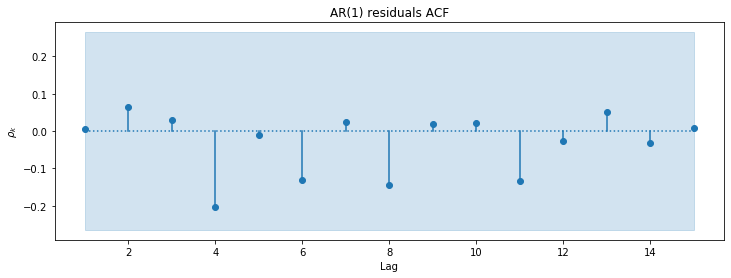

In [49]:
plot_residuals_acf(model.resid, 'AR(1) residuals ACF')

Residuals do not display significant autocorrelation individually.

In [50]:
ljung_box_test(r=acf(model.resid, fft=False, nlags=12)[1:], n=len(Y), k_ar=1)

{'X-squared': 6.469692567225901, 'df': 11, 'p-value': 0.8402616225542638}

Residuals do not display significant autocorrelation collectively.

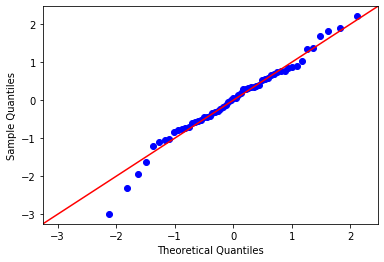

In [51]:
probplot = sm.ProbPlot(model.resid, fit=True)
fig = probplot.qqplot(line='45')
plt.show()

Q-Q plot is a bit questionable near the bottom tail.

In [52]:
shapiro(model.resid)[1]

0.5840598940849304

Shapiro-Wilk does not reject the hypothesis that residuals are normally distributed.